In [28]:
folder_to_chromatinhd_manuscript = "" # add here the folder to ChromatinHD_manuscript, make sure it ends with /
!ln -s /data/wsaelens/projects/chromatinhd/chromatinhd_manuscript/output {folder_to_chromatinhd_manuscript}

# if this worked correctly, this should contain several subfolders
!ls {folder_to_chromatinhd_manuscript}/output

ls: cannot access '/output': No such file or directory


In [29]:
# install chromatinhd package (in developer mode)
# you will first have to run this to install our package
# after running this, you will likely have to restart the notebook
folder_to_chromatinhd = "" # add here the folder to ChromatinHD, make sure it ends with /
!pip install -e {folder_to_chromatinhd}


Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

-e option requires 1 argument


In [30]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns
sns.set_style('ticks')
%config InlineBackend.figure_format='retina'

import pickle

import scanpy as sc

import pathlib

import torch

import tqdm.auto as tqdm

import chromatinhd as chd


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Information on histone marks

Based on research (and a bit of help from ChatGPT). Feel free at add your own information:

- H3K4me3 - This modification is typically associated with active gene transcription. It is often found at the promoter regions of genes, where it can help recruit transcription factors and other proteins that initiate transcription.
- H3K27ac - This modification is also associated with active gene transcription. It is often found near enhancer regions, which are regulatory regions that can increase gene expression.
- H3K27me3 - This modification is associated with gene repression. It is often found at regions of chromatin that are tightly packed and inaccessible to transcriptional machinery.
- H3K4me1 - This modification is associated with enhancer regions and is thought to help stabilize their structure.
- H3K9me3 - This modification is also associated with gene repression. It is often found at regions of chromatin that are densely packed and transcriptionally inactive.

 - H3K36me3 - This modification is associated with gene expression and is often found at the bodies of actively transcribed genes. It may help recruit proteins that are involved in elongation of the transcript during transcription. It is often correlated with high methylation in gene bodies (https://www.embopress.org/doi/full/10.15252/embj.201796812) and because it promotes DNA methylation, it is likely involved in avoiding aberrant transcription from intragenic transcription start sites.

It's important to note that the functions of these modifications can vary depending on the specific cell type and context in which they are found.

## Load different ChiP-seq files

In the `bw_folder`, I have downloaded a bunch of bigwig files from ENCODE, that measured histone marks using ChIP-seq from different blood cell types. You can find the overview of all data (which is only a subset of what we downloaded) here: https://www.encodeproject.org/immune-cells/?type=Experiment&replicates.library.biosample.donor.organism.scientific_name=Homo+sapiens&biosample_ontology.cell_slims=hematopoietic+cell&biosample_ontology.classification=primary+cell&control_type!=*&status!=replaced&status!=revoked&status!=archived&biosample_ontology.system_slims=immune+system&biosample_ontology.system_slims=circulatory+system&config=immune

In [2]:
encode_folder = chd.get_output() / "data" / "encode2"
bw_folder = encode_folder / "immune"

This following dataframe links all the identifiers form ENCODE, with the celltype/cluster identifiers we use in our ATAC-seq data. E.g. CD4 T = "naive thymus-derived CD4-positive, alpha-beta T cell" in ENCODE data.

In [3]:
biosamples_oi = pd.DataFrame([
    ["naive thymus-derived CD4-positive, alpha-beta T cell", "CD4 T"],
    ["naive thymus-derived CD8-positive, alpha-beta T cell", "CD8 T"],
    ["CD14-positive monocyte", "Monocytes"],
    ["naive B cell", "B"],
    ["B cell", "B"],
    ["immature natural killer cell", "NK"],
    ["natural killer cell", "NK"],
    ["dendritic cell", "cDCs"]
], columns = ["Biosample term name", "cluster"])

The following dataframe will contain information on the clusters, e.g. for now only what color they will have for plotting.

In [4]:
clusters_info = pd.DataFrame({"cluster":biosamples_oi["cluster"].unique()}).set_index("cluster")
clusters_info["color"] = sns.color_palette(n_colors = len(clusters_info))

The following file contains the information for all the files that we downloaded from ENCODE

In [5]:
files = pd.read_csv(bw_folder / "files.csv", index_col = 0)
files["target"] = files["Experiment target"].str.split("-").str[0]

# DNA methylation will have as "Experiment target" = NA, but we change it here to DNAme for consistency downstream
files.loc[pd.isnull(files["target"]), "target"] = "DNAme"
files.head()

,File accession,File format,File type,File format type,Output type,File assembly,Experiment accession,Assay,Donor(s),Biosample term id,...,File Status,s3_uri,Azure URL,File analysis title,File analysis status,Audit WARNING,Audit NOT_COMPLIANT,Audit ERROR,filename,target
0,ENCFF836ZHT,bigWig,bigWig,NaN,signal p-value,GRCh38,ENCSR374XMP,Mint-ChIP-seq,/human-donors/ENCDO911LCI/,CL:0000623,...,released,s3://encode-public/2022/03/31/aa53379a-f676-49...,https://datasetencode.blob.core.windows.net/da...,ENCODE4 v1.8.0 GRCh38,released,"mixed read lengths, mild to moderate bottlenec...",insufficient read depth,NaN,ENCFF836ZHT.bigWig,H3K36me3
1,ENCFF085PHK,bigWig,bigWig,NaN,signal p-value,GRCh38,ENCSR976RUD,Mint-ChIP-seq,/human-donors/ENCDO830ROH/,CL:0000900,...,released,s3://encode-public/2022/03/13/c4a13257-7b5c-47...,https://datasetencode.blob.core.windows.net/da...,ENCODE4 v1.8.0 GRCh38,released,"mixed read lengths, moderate library complexit...",NaN,NaN,ENCFF085PHK.bigWig,H3K36me3
2,ENCFF650YTD,bigWig,bigWig,NaN,signal p-value,GRCh38,ENCSR784UID,Mint-ChIP-seq,/human-donors/ENCDO833KUM/,CL:0000900,...,released,s3://encode-public/2021/06/19/99f578df-ca09-4e...,https://datasetencode.blob.core.windows.net/da...,ENCODE4 v1.8.0 GRCh38,released,mixed read lengths,NaN,NaN,ENCFF650YTD.bigWig,H3K9me3
3,ENCFF290UZL,bigWig,bigWig,NaN,signal p-value,GRCh38,ENCSR446PXV,Mint-ChIP-seq,/human-donors/ENCDO930DIF/,CL:0000900,...,released,s3://encode-public/2021/06/18/a2ade813-0445-47...,https://datasetencode.blob.core.windows.net/da...,ENCODE4 v1.8.0 GRCh38,released,"mixed read lengths, mild to moderate bottlenec...",NaN,NaN,ENCFF290UZL.bigWig,H3K27ac
4,ENCFF191GHE,bigWig,bigWig,NaN,signal p-value,GRCh38,ENCSR544QVA,Mint-ChIP-seq,/human-donors/ENCDO930DIF/,CL:0000900,...,released,s3://encode-public/2021/09/15/6c5fa1a9-b0a4-44...,https://datasetencode.blob.core.windows.net/da...,ENCODE4 v1.8.0 GRCh38,released,mixed read lengths,NaN,NaN,ENCFF191GHE.bigWig,H3K27me3


We got a bunch of marks:

In [6]:
files["target"].value_counts()

H3K4me3     62
H3K27ac     60
H3K27me3    58
H3K4me1     58
H3K9me3     57
H3K36me3    56
DNAme        6
H3K4me2      6
H4K20me1     2
H3K9ac       2
H2AFZ        2
H3K79me2     2
Name: target, dtype: int64

And a bunch of cell types:

In [7]:
files["Biosample term name"].value_counts()

naive thymus-derived CD4-positive, alpha-beta T cell    90
naive thymus-derived CD8-positive, alpha-beta T cell    66
CD14-positive monocyte                                  64
naive B cell                                            46
immature natural killer cell                            35
B cell                                                  33
natural killer cell                                     31
dendritic cell                                           6
Name: Biosample term name, dtype: int64

And what output they contain. For ChIP-seq it is signal p-value, while for methylation it is the raw signal.

In [8]:
files["Output type"].value_counts()

signal p-value                           365
plus strand methylation state at CpG       3
minus strand methylation state at CpG      3
Name: Output type, dtype: int64

## Load promoter positions

In [9]:
dataset_name = "pbmc10k"

folder_dataset = chd.get_output() / "data" / dataset_name

promoter_name, window = "10k10k", np.array([-10000, 10000])
promoters = pd.read_csv(folder_dataset / ("promoters_" + promoter_name + ".csv"), index_col = 0)

transcriptome = chd.data.Transcriptome(folder_dataset / "transcriptome")

### Load at a single file

Let's visualize the ChIP-seq data for one sample close to one gene.

In [10]:
import pyBigWig

In [11]:
idx_oi = files.query("`Biosample term name` == 'natural killer cell'").query("`target` == 'H3K4me3'").index[0]
idx_oi = files.query("`Biosample term name` == 'natural killer cell'").query("`target` == 'DNAme'").index[0]

In [12]:
bw = pyBigWig.open(str(bw_folder / files.iloc[idx_oi]["filename"]))

In [13]:
promoter = promoters.loc[transcriptome.gene_id("CCL4")]

In [14]:
plotdata = pd.DataFrame({
    "signal":np.array(bw.values(promoter.chr, promoter.start, promoter.end)),
    "position":np.arange(window[0], window[1])[::promoter["strand"]],
    "chrposition":np.arange(promoter.start, promoter.end)
})

(36113826.0, 36093827.0)

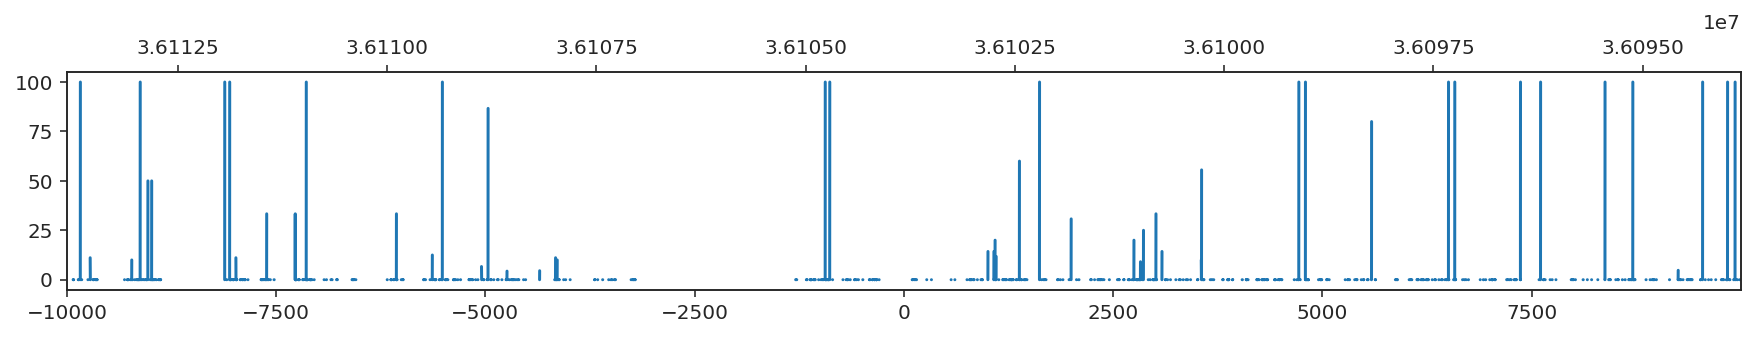

In [15]:
fig, ax = plt.subplots(figsize = (15, 2))
ax.plot(plotdata["position"], plotdata["signal"])
ax.set_xlim(plotdata["position"].min(), plotdata["position"].max())
ax2 = ax.twiny()
ax2.set_xlim([plotdata["chrposition"].max(), plotdata["chrposition"].min()][::promoter["strand"]])

0 represents the transcription start site, while positive numbers represent (part of) the gene body, negative numbers is everything upstream from the promoter. I also add a second x-axis that gives you the real coordinates on the chromosome (according to the Grch38 assembly).

### Explore multiple tracks

Let's visualize the ChIP-seq data for a couple of samples from different cell types

In [16]:
files_oi = pd.merge(files, biosamples_oi)

clusters_oi = clusters_info.loc[['NK', 'Monocytes', 'CD4 T', 'B', 'CD8 T']]
files_oi = files_oi.query("cluster in @clusters_oi.index")

targets = ['H3K36me3']
files_oi = files_oi.query("target in @targets")

files_oi = files_oi.copy()
files_oi["file"] = [pyBigWig.open(str(bw_folder / file["filename"])) for _, file in files_oi.iterrows()]
files_oi.index.name = "file_ix"

files_oi = files_oi.sort_values("cluster")

In [17]:
signals = {}
for file_ix, file in files_oi.iterrows():
    bw = file["file"]
    signal = np.array(bw.values(promoter.chr, promoter.start, promoter.end))
    signal_file = pd.Series(np.log(signal+0.01))
    signals[file_ix] = signal_file
signals = pd.concat(signals, axis = 1).T
signals.columns = np.arange(promoter.start, promoter.end)

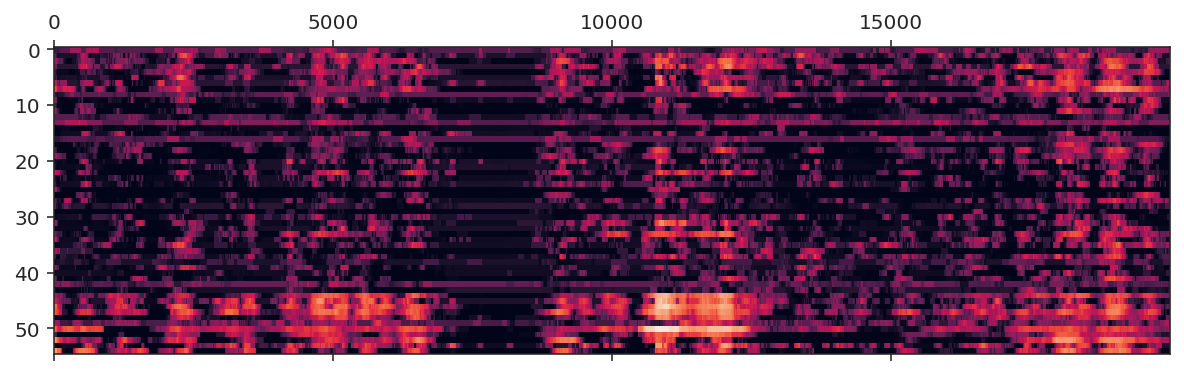

In [18]:
fig, ax = plt.subplots(figsize = (10, 3))
plotdata = signals
ax.matshow(plotdata, aspect = 100)

In [19]:
signals_tmp = signals.copy()
signals_tmp.index = files_oi.loc[signals_tmp.index, "cluster"]
signals_clusters = signals_tmp.groupby(level = 0).mean()

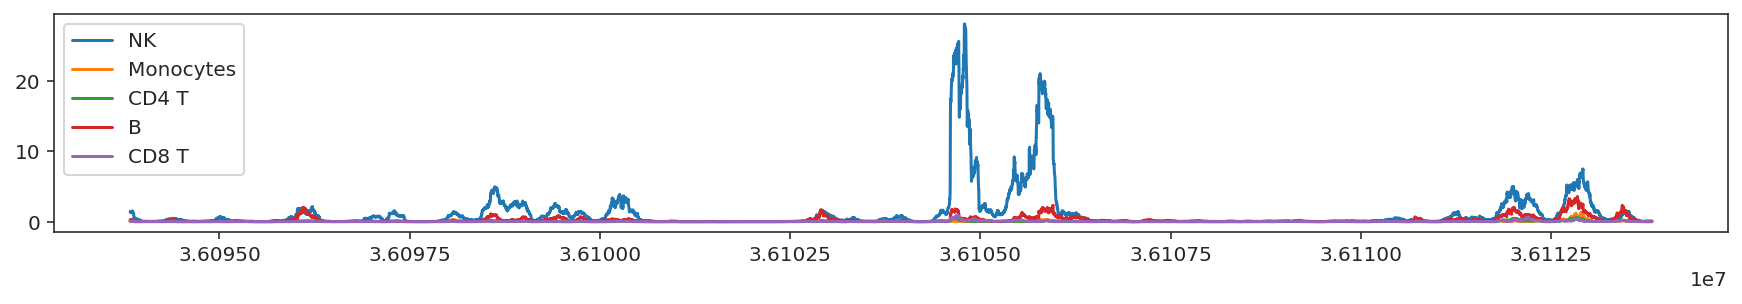

In [20]:
fig, ax = plt.subplots(figsize = (15, 2))
for cluster in clusters_oi.index:
    ax.plot(signals_clusters.columns, np.exp(signals_clusters.loc[cluster]), label = cluster)
ax.legend()

<AxesSubplot:ylabel='cluster'>

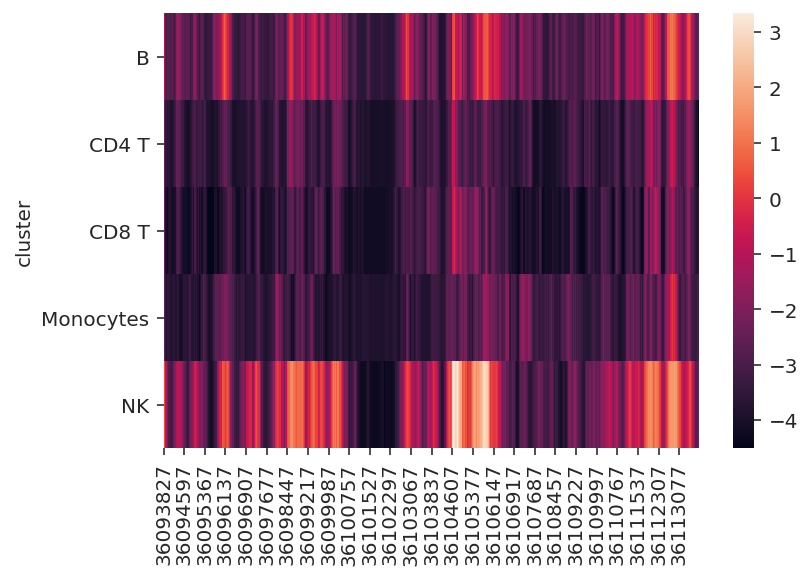

In [21]:
sns.heatmap(signals_clusters)

## Combine with different types differential ATAC-seq regions

Let's visualize the signal for a particular gene (CCL4) across different cell types and markers (`targets`)

In [22]:
files_oi = pd.merge(files, biosamples_oi)

clusters_oi = clusters_info.loc[['NK', 'Monocytes', 'CD4 T', 'B', 'CD8 T']]
files_oi = files_oi.query("cluster in @clusters_oi.index")

targets = [
    "H3K4me3",
    "H3K27ac",
    "H3K27me3",
    "H3K4me1",
    "H3K9me3",
    "H3K36me3",
    "DNAme",
]
files_oi = files_oi.query("target in @targets")

files_oi = files_oi.copy()
files_oi["file"] = [pyBigWig.open(str(bw_folder / file["filename"])) for _, file in files_oi.iterrows()]
files_oi.index.name = "file_ix"

files_oi = files_oi.sort_values("cluster")

In [23]:
promoter = promoters.loc[transcriptome.gene_id("CCL4")]

Load in the "slicetopologies".
This contains all the regions that were differentially accessible in a particular cell type (=`cluster`), and how these slices looked like (=`type`). It also contains where these regions are located (`chr`, `start`, `end`). The goal is now to compare how these different shapes of differentially accessibly regions are related to chromatin marks.

In [24]:
prediction_path = chd.get_output() / "prediction_likelihood/pbmc10k/10k10k/leiden_0.1/v9_128-64-32"
scores_dir = prediction_path / "scoring" / "significant_up"
scores_file = scores_dir / "slicetopologies.csv"
slicetopologies = pd.read_csv(scores_file, index_col = 0)

In [25]:
analysis_folder = prediction_path / "encode_marks"
analysis_folder.mkdir(exist_ok = True, parents = True)

Some functions that extract all the ChIP-seq data around a gene, and that will aggregate this across different ChIP-seq samples.

In [26]:
def get_signals(files_oi, promoter):
    signals = {}
    for file_ix, file in files_oi.iterrows():
        bw = file["file"]
        signal = np.array(bw.values(promoter.chr, promoter.start, promoter.end))
        signal_file = pd.Series(signal)
        signals[file_ix] = signal_file
    signals = pd.concat(signals, axis = 1).T
    signals.columns = np.arange(promoter.start, promoter.end)
    return signals
signals = get_signals(files_oi, promoter)

In [27]:
def get_signals_clusters(signals):
    signals_tmp = signals.copy()
    signals_tmp.index = pd.MultiIndex.from_frame(files_oi.loc[signals_tmp.index, ["cluster", "target"]])
    signals_clusters = signals_tmp.groupby(level = ["cluster", "target"]).mean()
    return signals_clusters
signals_clusters = get_signals_clusters(signals)
normsignal_clusters = (
    signals_clusters / 
    signals_clusters.groupby("target").max().max(1)[signals_clusters.index.get_level_values("target")].values[:, None]
)

In [28]:
target_info = pd.DataFrame({"target":targets}).set_index("target")
target_info["color"] = sns.color_palette(n_colors = len(target_info))
target_info["label"] = target_info.index

Plot for each cell type and for each mark its average signal.
Also plot on top the different types of differential accessibility regions.
See powerpoint for color code

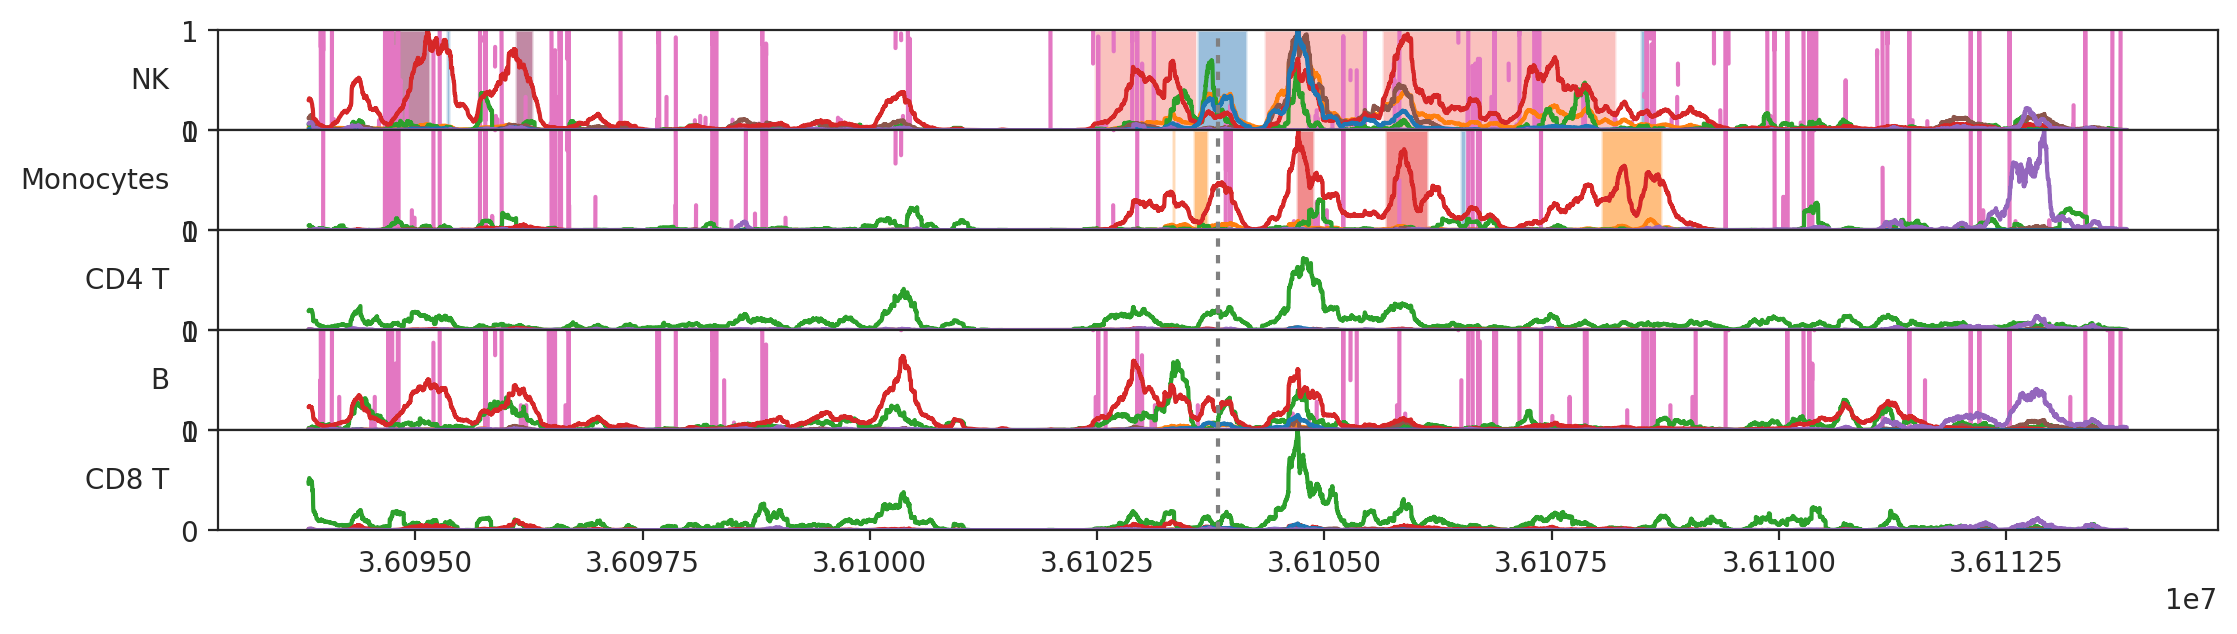

In [30]:
slicetopologies_oi = slicetopologies.query("gene == @promoter.name")
main = chd.grid.Grid(padding_height = 0)
fig = chd.grid.Figure(main)

ymax = 1

for cluster_ix, cluster in enumerate(clusters_oi.index):
    panel = main[cluster_ix, 0] = chd.grid.Ax(dim = (10, 0.5))
    ax = panel.ax
    
    normsignal_cluster = normsignal_clusters.loc[cluster]
    
    for target, normsignal_target in normsignal_cluster.iterrows():
        ax.plot(
            normsignal_target.index,
            normsignal_target,
            color = target_info.loc[target, "color"],
        )
    
    for _, slice in slicetopologies_oi.query("cluster == @cluster").iterrows():
        ax.axvspan(slice["start"], slice["end"], fc = chd.slicetypes.types_info.loc[slice["type"], "color"], alpha = 0.5)
    ax.set_ylim(0, ymax)
    ax.set_ylabel(cluster, rotation = 0, ha = "right", va = "center")
    ax.axvline(promoter["tss"], dashes = (2, 2), color = "grey")
    
    # invert the xaxis if the gene would go in the other direction
    # this makes it so that the gene body is also to the right of the plot
    if promoter.strand == -1:
        ax.xaxis.invert_xaxis()
    
fig.plot()

Color code for all the tracks

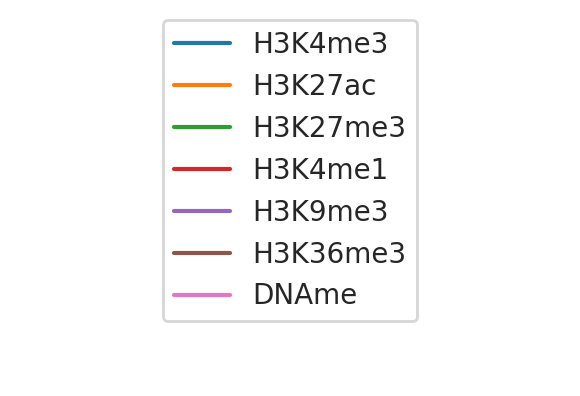

In [31]:
# create a standalone legend
def create_color_legend(data):
    fig_fake, ax_fake = plt.subplots()
    lines = []
    for _, data_ in data.iterrows():
        lines.append(ax_fake.plot([0, 1], [0, 1], color = data_["color"])[0])
    plt.close()

    fig, ax = plt.subplots(figsize=(3,2))
    ax.axis("off")
    fig.legend(lines, data["label"], bbox_to_anchor=(0.5, 1.), loc = "upper center")
    fig.tight_layout()
    fig.show()
    return fig
create_color_legend(target_info);

## Absolute signal within each region

We want to answer the question: how are different shapes (or "topologies") of differential DNA accessibility associated with different histone marks?

There are multiple ways to answer this question.

We're first going to do it in the most simplistic way, and perhaps dig deeper later.

The simplest way would be to take all the regions that are differential in a particular cell type, and look at the average signal for a chromatin mark in the particular region in the samples from the particular cell type. In other words, we will average both across a whole region and across all samples.

For speed, we're at first only doing it for the first 10000 slices/regions. To do the actual analysis, we will of course look at all regions in the future, but you can just look at these regions for now to do some initial exploration. Also, because this takes some time I'm first extracting the information from the bigwig files, saving it, and reading it back in to do the plotting, normalization and analysis later. That way you can play around with the interpretation/plotting without having to rerun this code block all the time.

In [32]:
slicetopologies_oi = slicetopologies.query("cluster in @clusters_oi.index").head(10000) # select the first 10k regions
slicetopologies_oi.index.name = "slice_ix"

In [33]:
signals_slices = {}

# for each slice
for slice_ix, slicetopology in tqdm.tqdm(slicetopologies_oi.iterrows(), total = len(slicetopologies_oi)):
    signals = []
    file_ixs = []
    
    # select  for only the celltypes in which the slice was differential
    for file_ix, file in files_oi.loc[files_oi["cluster"] == slicetopology["cluster"]]["file"].items():
        signals.append(np.array(file.values(slicetopology.chr, slicetopology.start, slicetopology.end)))
        file_ixs.append(file_ix)
        
    # stack the signal from the different files (i.e. samples) and then calculate the mean for each target (=mark)
    signals = pd.DataFrame(np.stack(signals), index = file_ixs)
    signals.index = files_oi.loc[file_ixs, "target"]
    signals_slices[slice_ix] = signals

100%|██████████| 10000/10000 [38:21<00:00,  4.34it/s] 


In [35]:
pickle.dump(signals_slices, (analysis_folder / "signals_slices.pkl").open("wb"))

Load in the data again

In [36]:
signals_slices = pickle.load((analysis_folder / "signals_slices.pkl").open("rb"))

Take the mean for each 

In [37]:
signal_topologies = []
for slice_ix, slicetopology in tqdm.tqdm(slicetopologies_oi.iterrows(), total = len(slicetopologies_oi)):
    # to take the
    # signals = np.exp(np.log(signals_slices[slice_ix] + 1e-5).groupby(level = 0).mean().mean(1))
    signals = signals_slices[slice_ix].groupby(level = 0).mean().mean(1)
    signal_topologies.append(pd.DataFrame({"slice_ix":slice_ix, "signal":signals.values, "target":signals.index}))
signal_topologies = pd.concat(signal_topologies)

100%|██████████| 10000/10000 [00:09<00:00, 1104.02it/s]


We can now calculate the mean across different types of slices and different targets:

In [38]:
signal_topologies_mean = signal_topologies.join(slicetopologies_oi[["type"]], on = "slice_ix").groupby(["type", "target"])["signal"].mean().unstack()

In [39]:
# do max normalization for each mark
signal_topologies_mean_norm = signal_topologies_mean / signal_topologies_mean.values.max(0)

<AxesSubplot: xlabel='type', ylabel='target'>

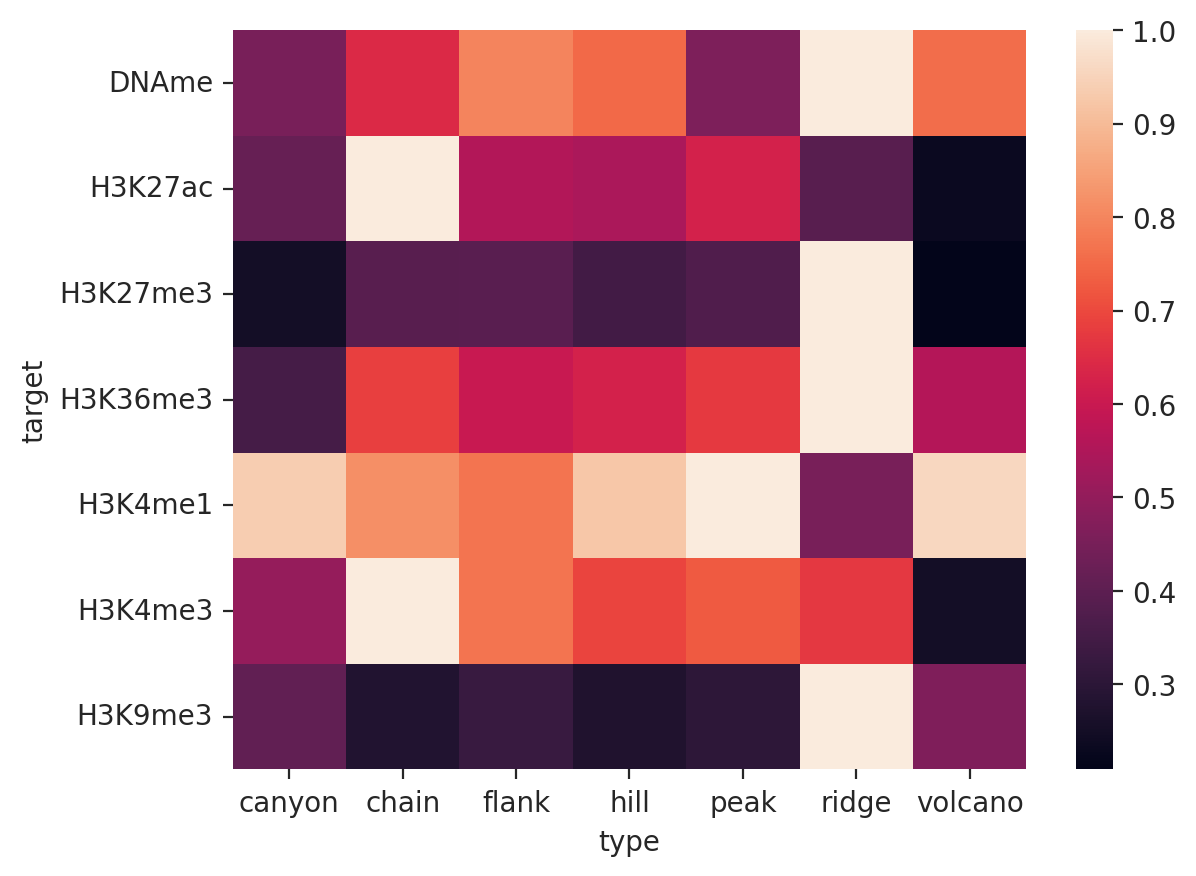

In [44]:
sns.heatmap(signal_topologies_mean_norm.T)

You can see that on average there is a clear link between some slice topologies and histone marks. For example, ridges are clearly linked with H3K36me3 and DNA methylation, probably because they are often found in highly expressed genes, and there is therefore a need to shut off aberrant transcription start sites (see e.g. https://www.embopress.org/doi/full/10.15252/embj.201796812). 

For now we just looked at the signal of a mark within the cell type itself: for a given differential accessibility slice within cell type X, we just looked at the ChIP-seq mark signal within cell type X.

The question I would want you to explore now is: could you look at this differentially? In other words, how much higher is a mark in cell type X versus the same mark in the same region for all other cell types?

For this, you will need to:
- Extract the signal for each slice across all cell types.
- Calculate the average signal within each slice for each cell type
- Compare these average for cell type X (the cell type where the slice was found) with the average for all other cell types. I would calculate the fold change here, i.e. `(signal in cell type X)/(average signal in all other cell types)
- Take the log of this fold change.
- Calculate the average of the fold changes across each combination of slice type and target.
- Create a heatmap as before